# Bone Anatomical Measurements
This notebook measures the subject-specific anatomical measurements from the 3D bone surface meshes
    

## imports and user-defined properties

In [1]:
import numpy as np
import meshplot as mp
import igl
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import wildmeshing as wm
import json
import miniball

sys.path.append('../')

import src

# Please first clone the RAINBOW github repository and change this directory to the "python" folder inside RAINBOW.
# RAINBOW github: https://github.com/diku-dk/RAINBOW
sys.path.append (str(Path.home()/'Documents'/'Github'/'RAINBOW'/'python'))
from rainbow.geometry.surface_mesh import *


INPUT SUBJECT INFORMATION:

- model_id: choose between m1 -> m11 to select one of the detaset in the repository.
- i_dim, o_dim: the input and output dimension ( 'mm' = millimeters, 'm' = meters )
- o_format: a '.csv' file containing the bone anatomical measurements

In [2]:
# model id
model_id = 'm1'

# dimensions 
i_dim  = 'mm'     
o_dim  = 'mm'

# suffix
i_format = '.obj'
o_format = '.csv'

DIRECTORIES and PATHS:
- main_dir: locate this directory to where the libhip repository is cloned to.
- i_dir:  the directory of the input bone surface mesh files.
- anatomical_dir: the directory of the anatomical measurements of the bone and cartilage models.
- config_path: path to the subject-specific parameters to measure the lowest point of the femur bone from.

In [3]:
main_dir = Path('..')

i_dir     = main_dir/ 'model_generation'/ 'preprocessing_output'/ model_id
ant_o_dir = main_dir/ 'model_generation'/ 'mid_outputs'/ 'ant_output'/ model_id
o_dir     = main_dir/ 'model_generation'/ 'anatomical_info'
    
config_name  = model_id + '_config'
config_path  = str((main_dir/ 'config'/ config_name).with_suffix('.yml'))
config       = src.Config (config_path)

lh_fc_p_path = str(ant_o_dir) +'/' + model_id + '_lhj_fc_base_faces.npy'
rh_fc_p_path = str(ant_o_dir) +'/' + model_id + '_rhj_fc_base_faces.npy'

In [4]:
# bone input paths
i_bone_tag = model_id + '_clean_'

i_sacrum  = i_bone_tag + 'sacrum_'  + i_dim
i_lpelvis = i_bone_tag + 'lpelvis_' + i_dim
i_rpelvis = i_bone_tag + 'rpelvis_' + i_dim
i_lfemur  = i_bone_tag + 'lfemur_'  + i_dim
i_rfemur  = i_bone_tag + 'rfemur_'  + i_dim

i_sacrum_path  = str((i_dir/ i_sacrum).with_suffix(i_format))
i_lpelvis_path = str((i_dir/ i_lpelvis).with_suffix(i_format))
i_rpelvis_path = str((i_dir/ i_rpelvis).with_suffix(i_format))
i_lfemur_path  = str((i_dir/ i_lfemur).with_suffix(i_format))
i_rfemur_path  = str((i_dir/ i_rfemur).with_suffix(i_format))

In [5]:
s_vertices, s_faces  = src.read (i_sacrum_path, i_dim) 
lp_vertices,lp_faces = src.read (i_lpelvis_path, i_dim)
rp_vertices,rp_faces = src.read (i_rpelvis_path, i_dim) 
lf_vertices,lf_faces = src.read (i_lfemur_path, i_dim)
rf_vertices,rf_faces = src.read (i_rfemur_path, i_dim) 

number of faces after reading 46456
number of faces after reading 35806
number of faces after reading 35600
number of faces after reading 24966
number of faces after reading 25366


## The hip joint center (HJC), the simplified radius (SR), and the actual radius (AR)
We fit a sphere to the femoral head:
- The center of this sphere is considered as the hip joint center (HJC).
- The radius of this sphere is considered as the simplified femoral head radius (SR).
- We measure the distance from the HJC to the actual femoral head surface mesh (AR) to see how the geometry
of the femoral head deviates from a sphere. To this purpose, we first separate the relative portion of the femoral head.

In [6]:
def fit_sphere_femur(vertices):

    # fit a sphere to ROi
    c, r2 = miniball.get_bounding_ball(vertices)
    r     = np.round(np.sqrt(r2),2)
    c1    = np.round(c,2)

    # create the sphere for femur
    s_vertices, s_faces   = create_sphere ( r, 50, 50 )

    s_vertices  = s_vertices + c

    return s_vertices, s_faces, c1, r

lh_fc_p_faces = np.load (lh_fc_p_path, allow_pickle=True)
rh_fc_p_faces = np.load (rh_fc_p_path, allow_pickle=True)

lsphr_vertices, lsphr_faces, l_hjc, l_sr = fit_sphere_femur(lh_fc_p_faces)
rsphr_vertices, rsphr_faces, r_hjc, r_sr = fit_sphere_femur(rh_fc_p_faces)

print ('the left hip joint center (HJC):',l_hjc, 'mm' )
print ('the right hip joint center (HJC)',r_hjc, 'mm' )

print ('the left simplified femoral head radius (SR):', l_sr, 'mm')
print ('the right simplified femoral head radius (SR):', r_sr, 'mm')
    
frame = mp.plot(rf_vertices, rf_faces, c=src.bone, shading=src.sh_false)
frame.add_mesh(rsphr_vertices, rsphr_faces, c=src.sweet_pink, shading=src.sh_false)
frame.add_mesh(lsphr_vertices, lsphr_faces, c=src.sweet_pink, shading=src.sh_false)
frame.add_mesh(lf_vertices, lf_faces, c=src.bone, shading=src.sh_false)



the left hip joint center (HJC): [  85.91   19.62 -578.28] mm
the right hip joint center (HJC) [ -86.49   24.58 -583.51] mm
the left simplified femoral head radius (SR): 26.95 mm
the right simplified femoral head radius (SR): 27.88 mm


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-103.6234…

3

In [7]:
# left side
tetra = wm.Tetrahedralizer(epsilon=0.001, edge_length_r=0.1)
tetra.set_meshes([lf_vertices,lsphr_vertices],[lf_faces,lsphr_faces])
tetra.tetrahedralize()

lfh_v, lfh_t = tetra.get_tet_mesh_from_csg(json.dumps({"operation":"intersection", "left": 1, "right": 0}))
lfh_v, lfh_t, _, _ = igl.remove_unreferenced(lfh_v, lfh_t)
lfh_f = igl.boundary_facets(lfh_t)
lfh_faces = np.copy(lfh_f)
lfh_faces[:, [0, 1]] = lfh_faces[:, [1, 0]]
lfh_vertices, lfh_faces = src.clean(lfh_v, lfh_faces)

# right side
tetra = wm.Tetrahedralizer(epsilon=0.001, edge_length_r=0.1)
tetra.set_meshes([rf_vertices,rsphr_vertices],[rf_faces,rsphr_faces])
tetra.tetrahedralize()

rfh_v, rfh_t = tetra.get_tet_mesh_from_csg(json.dumps({"operation":"intersection", "left": 1, "right": 0}))
rfh_v, rfh_t, _, _ = igl.remove_unreferenced(rfh_v, rfh_t)
rfh_f = igl.boundary_facets(rfh_t)
rfh_faces = np.copy(rfh_f)
rfh_faces[:, [0, 1]] = rfh_faces[:, [1, 0]]
rfh_vertices, rfh_faces = src.clean(rfh_v, rfh_faces)

# frame = mp.plot(rfh_vertices, rfh_faces, c = src.bone, shading = src.sh_true)
# frame.add_mesh(lfh_vertices, lfh_faces, c = src.bone, shading = src.sh_true)

In [8]:
# left side
lfh_bc = igl.barycenter(lfh_vertices, lfh_faces)

l_ar = []
for i in lfh_bc:
    ldis = np.sqrt((l_hjc[0]-i[0])**2 + (l_hjc[1]-i[1])**2 + (l_hjc[2]-i[2])**2)
    l_ar.append(ldis)
l_ar = np.array(l_ar)

l_ar_mean = np.mean(l_ar)    
    
# lfemoral head radius
rfh_bc = igl.barycenter(rfh_vertices, rfh_faces)

r_ar = []
for i in rfh_bc:
    rdis = np.sqrt((r_hjc[0]-i[0])**2 + (r_hjc[1]-i[1])**2 + (r_hjc[2]-i[2])**2)
    r_ar.append(rdis)
r_ar = np.array(r_ar)

r_ar_mean = np.mean(r_ar)

print('the mean AR in the left femoral head', np.round(l_ar_mean,2))
print('the mean AR in the right femoral head', np.round(r_ar_mean,2))

the mean AR in the left femoral head 26.15
the mean AR in the right femoral head 26.91


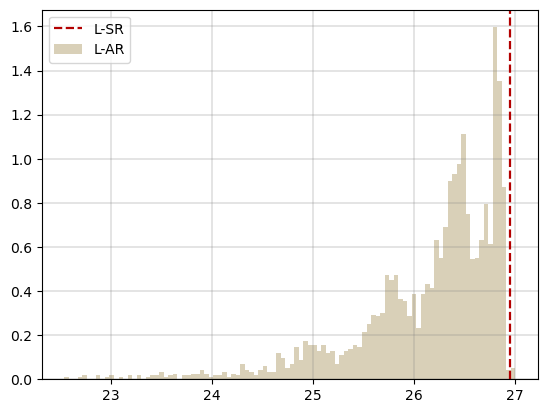

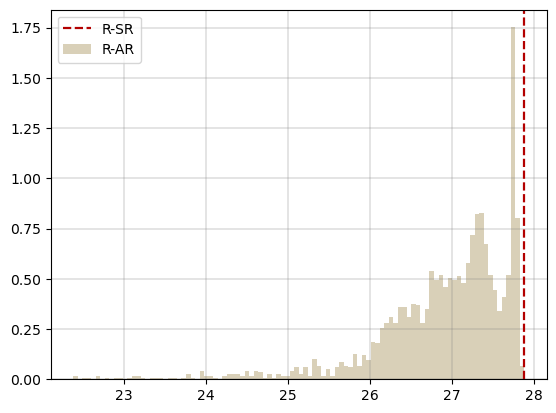

In [9]:
fig, ax = plt.subplots()

# histogram
num_bins = 100
n, bins, patches = ax.hist(l_ar, num_bins, density=True, color=src.dark_bone, label='L-AR')

plt.axvline(l_sr, color=src.dark_red, linestyle='dashed', linewidth=1.6,label='L-SR')
plt.legend(loc='upper left')
plt.grid(color=np.array([128, 128, 128])/255., linestyle='-', linewidth=0.3)

plt.show()

fig, ax = plt.subplots()

# histogram
num_bins = 100
n, bins, patches = ax.hist(r_ar, num_bins, density=True, color=src.dark_bone, label='R-AR')

plt.axvline(r_sr, color=src.dark_red, linestyle='dashed', linewidth=1.6,label='R-SR')
plt.legend(loc='upper left')
plt.grid(color=np.array([128, 128, 128])/255., linestyle='-', linewidth=0.3)

plt.show()


## The visible femur length (VFL)
We define the visible femur length as the length of the line connecting the most proximal point of the femur to the mid-point of the most distal part of the same bone

In [10]:
# the most proximal point in the femur
lf_prox_vertex_idx = np.where(lf_vertices[:,2] == np.max(lf_vertices[:,2]))[0]
lf_prox = lf_vertices[lf_prox_vertex_idx]

rf_prox_vertex_idx = np.where(rf_vertices[:,2] == np.max(rf_vertices[:,2]))[0]
rf_prox = rf_vertices[rf_prox_vertex_idx]

# the most distal part of the femur bones ( this data is measured from the CT scans)
config_ant = config.ant_var

lf_dist_x  = config_ant.l_distal_midpoint_x
lf_dist_y  = config_ant.l_distal_midpoint_y
lf_dist_z  = config_ant.l_distal_midpoint_z

rf_dist_x  = config_ant.r_distal_midpoint_x
rf_dist_y  = config_ant.r_distal_midpoint_y
rf_dist_z  = config_ant.r_distal_midpoint_z

l_vfl = np.sqrt((lf_prox[0,0]-lf_dist_x)**2 + (lf_prox[0,1]-lf_dist_y)**2 + (lf_prox[0,2]-lf_dist_z)**2)
r_vfl = np.sqrt((rf_prox[0,0]-rf_dist_x)**2 + (rf_prox[0,1]-rf_dist_y)**2 + (rf_prox[0,2]-rf_dist_z)**2)

print('The visible left femoral length:',np.round(l_vfl,2), 'mm')
print('The visible right femoral length:',np.round(r_vfl,2), 'mm')

frame = mp.plot(lf_vertices, lf_faces, c = src.bone, shading = src.sh_false)
frame.add_points(np.array([[lf_dist_x, lf_dist_y,lf_dist_z]]), shading={"point_size": 30, "point_color": "red"})
frame.add_points(np.array([lf_prox]), shading={"point_size": 30, "point_color": "red"})
frame.add_lines(np.array([[lf_dist_x, lf_dist_y,lf_dist_z]]), lf_prox, shading={"line_color": "red"})

frame.add_mesh(rf_vertices, rf_faces, c = src.bone, shading = src.sh_false)
frame.add_points(np.array([[rf_dist_x,rf_dist_y,rf_dist_z]]), shading={"point_size": 30, "point_color": "red"})
frame.add_points(np.array([rf_prox]), shading={"point_size": 30, "point_color": "red"})
frame.add_lines(np.array([[rf_dist_x,rf_dist_y,rf_dist_z]]), rf_prox, shading={"line_color": "red"})
    

The visible left femoral length: 232.66 mm
The visible right femoral length: 228.31 mm


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(103.94103…

7

## The interhip separation (IHS)
The Inter-hip separation is assumed as the distance between the paired hip joint centers

In [11]:
ihs = np.sqrt((l_hjc[0]-r_hjc[0])**2 + (l_hjc[1]-r_hjc[1])**2 + (l_hjc[2]-r_hjc[2])**2)

print('the length of the interhip separation is:' , np.round(ihs,2))

frame = mp.plot( lp_vertices, lp_faces, c = src.bone, shading = src.sh_false )
frame.add_mesh(rp_vertices, rp_faces, c = src.bone, shading = src.sh_false)
frame.add_lines(l_hjc, r_hjc, shading={"line_color": "green"})
frame.add_points(np.array([l_hjc]), shading={"point_size": 30, "point_color": "green"})
frame.add_points(np.array([r_hjc]), shading={"point_size": 30, "point_color": "green"})


the length of the interhip separation is: 172.55


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(71.973256…

4

## The height of ilium (IH)
The height of ilium is the vertical distance between the most superior part of the hip bones and the hip joint center.

In [12]:
lpp_idx = np.where(lp_vertices[:,2] == np.max(lp_vertices[:,2]))[0]
rpp_idx = np.where(rp_vertices[:,2] == np.max(rp_vertices[:,2]))[0]

lpp = lp_vertices[lpp_idx]
rpp = rp_vertices[rpp_idx]

l_ih = lpp[0,2] - l_hjc[2]
print('hegiht of left ilium', np.round(l_ih,2))

r_ih = rpp[0,2] - r_hjc[2]
print('hegiht of right ilium', np.round(r_ih,2))

l_ih_test = [lpp[0,0],lpp[0,1],l_hjc[2]]
r_ih_test = [rpp[0,0],rpp[0,1],r_hjc[2]]

frame = mp.plot( lp_vertices, lp_faces, c = src.bone, shading = src.sh_false )
frame.add_mesh(rp_vertices, rp_faces, c = src.bone, shading = src.sh_false)
frame.add_points(lpp, shading={"point_size": 30, "point_color": "red"})
frame.add_points(rpp, shading={"point_size": 30, "point_color": "red"})
frame.add_lines(lpp, np.array([l_hjc]), shading={"line_color": "blue"})
frame.add_lines(lpp, np.array([l_ih_test]), shading={"line_color": "black"})
frame.add_lines(rpp, np.array([r_ih_test]), shading={"line_color": "black"})
frame.add_lines(rpp, np.array([r_hjc]), shading={"line_color": "blue"})
frame.add_points(np.array([l_ih_test]), shading={"point_size": 30, "point_color": "black"})
frame.add_points(np.array([r_ih_test]), shading={"point_size": 30, "point_color": "black"})
frame.add_points(np.array([l_hjc]), shading={"point_size": 30, "point_color": "green"})
frame.add_points(np.array([r_hjc]), shading={"point_size": 30, "point_color": "green"})


hegiht of left ilium 153.71
hegiht of right ilium 156.57


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(71.973256…

11

## The width of ilium (IW)
The width of ilium is defined by the horizontal distance between the hip joint center and the most lateral point of the hip bones

In [13]:
lh_lateral_idx = np.where(lp_vertices[:,0] == np.max(lp_vertices[:,0]))[0]
lh_lateral = lp_vertices[lh_lateral_idx]

rh_lateral_idx = np.where(rp_vertices[:,0] == np.min(rp_vertices[:,0]))[0]
rh_lateral = rp_vertices[rh_lateral_idx]

l_iw  =  lh_lateral[0,0]- l_hjc[0]
print('width of left ilium',np.round(l_iw,2))

r_iw  =  r_hjc[0] -  rh_lateral[0,0]
print('width of right ilium',np.round(r_iw,2))

l_iw_test = [lh_lateral[0,0],l_hjc[1],l_hjc[2]]
r_iw_test = [rh_lateral[0,0],r_hjc[1],r_hjc[2]]

frame = mp.plot(lp_vertices, lp_faces, c = src.bone, shading = src.sh_false)
frame.add_mesh(rp_vertices, rp_faces, c = src.bone, shading = src.sh_false)
frame.add_points(np.array([l_hjc]), shading={"point_size": 30, "point_color": "red"})
frame.add_points(np.array([r_hjc]), shading={"point_size": 30, "point_color": "red"})
frame.add_lines(np.array([l_hjc]), np.array([l_iw_test]), shading={"line_color": "black"})
frame.add_lines(np.array([r_hjc]), np.array([r_iw_test]), shading={"line_color": "black"})
frame.add_lines(np.array([l_hjc]), lh_lateral, shading={"line_color": "blue"})
frame.add_lines(np.array([r_hjc]), rh_lateral, shading={"line_color": "blue"})
frame.add_points(lh_lateral, shading={"point_size": 30, "point_color": "blue"})
frame.add_points(rh_lateral, shading={"point_size": 30, "point_color": "blue"})
frame.add_points(np.array([l_iw_test]), shading={"point_size": 30, "point_color": "black"})
frame.add_points(np.array([r_iw_test]), shading={"point_size": 30, "point_color": "black"})


width of left ilium 56.8
width of right ilium 61.06


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(71.973256…

11

## Width of the pelvis (PW)
The width of the pelvis is explained as the distance between the most lateral point of the hip bones

In [14]:
pw = np.sqrt((lh_lateral[0,0]-rh_lateral[0,0])**2 + (lh_lateral[0,1]-rh_lateral[0,1])**2 + (lh_lateral[0,2]-rh_lateral[0,2])**2)
print('width of the pelvis',np.round(pw,2))

frame = mp.plot(lp_vertices, lp_faces, c = src.bone, shading = src.sh_false )
frame.add_mesh(rp_vertices, rp_faces, c = src.bone, shading = src.sh_false)
frame.add_points(lh_lateral, shading={"point_size": 30, "point_color": "blue"})
frame.add_points(rh_lateral, shading={"point_size": 30, "point_color": "blue"})
frame.add_lines(lh_lateral, rh_lateral, shading={"line_color": "blue"})


width of the pelvis 290.34


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(71.973256…

4

In [15]:
bone_df = {'Bone_anatomical_info':['The Interhip Separation', 'Height of the Left Ilium (L_IH)', 'Height of the Right Ilium (L_IH)', 
                      'Width of the Left Ilium (L_IW)','Width of the Right Ilium (R_IW)','Width of the pelvis (PW)',
                      'The Left Hip Joint Center (L_HJC)','The Right Hip Joint Center (R_HJC)', 'The Left Simplified Radius (L_SR)', 'The Right Simplified Radius (R_SR)',
                     'The Left Mean Actual Radius (L_M_AR)','The Right Mean Actual Radius (R_M_AR)',
                           'The Left Femur Distal Mid-point','The Right Femur Distal Mid-point',
                      'The Visible Left Femur Length (L_VFL)', 'The Visible Right Femur Length (R_VFL)'
                     ],
        model_id:[np.round(ihs,2), np.round(l_ih,2), np.round(r_ih,2), 
                    np.round(l_iw,2), np.round(r_iw,2),np.round(pw,2),
                    np.round(l_hjc,2), np.round(r_hjc,2),np.round(l_sr,2),np.round(r_sr,2),
                    np.round(l_ar_mean),np.round(r_ar_mean),
                    np.array([[lf_dist_x, lf_dist_y,lf_dist_z]]),np.array([[rf_dist_x, rf_dist_y,rf_dist_z]]),
                    np.round(l_vfl,2),np.round(r_vfl,2)
                   ]}
# Print the output 
bone_df = pd.DataFrame(bone_df)
print(bone_df)
    
bone_dfn = model_id + '_bone_ant'
path = str((o_dir/bone_dfn).with_suffix(o_format))

bone_df.to_csv(path)

                      Bone_anatomical_info  \
0                  The Interhip Separation   
1          Height of the Left Ilium (L_IH)   
2         Height of the Right Ilium (L_IH)   
3           Width of the Left Ilium (L_IW)   
4          Width of the Right Ilium (R_IW)   
5                 Width of the pelvis (PW)   
6        The Left Hip Joint Center (L_HJC)   
7       The Right Hip Joint Center (R_HJC)   
8        The Left Simplified Radius (L_SR)   
9       The Right Simplified Radius (R_SR)   
10    The Left Mean Actual Radius (L_M_AR)   
11   The Right Mean Actual Radius (R_M_AR)   
12         The Left Femur Distal Mid-point   
13        The Right Femur Distal Mid-point   
14   The Visible Left Femur Length (L_VFL)   
15  The Visible Right Femur Length (R_VFL)   

                                               m1  
0                                          172.55  
1                                          153.71  
2                                          156.57  
3        